The model was trained on images at 112x112. However, given that it is a FCN, it should accept larger images. See what that looks like.

In [1]:
from net import WaterNet
from data import transform
import cv2
from pathlib import Path
import torch
import numpy as np
from einops import rearrange
import pickle
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Util fxns

In [10]:
def arr2ten(arr):
    """Convert arr2ten plus scaling"""
    ten = torch.from_numpy(arr) / 255
    ten = rearrange(ten, "h w c -> 1 c h w")
    return ten

def ten2arr(ten):
    """Convert ten2arr plus scaling"""
    arr = ten.cpu().detach().numpy()
    arr = np.clip(arr, 0, 1)
    arr = (arr * 255).astype(np.uint8)
    arr = rearrange(arr, "c h w -> h w c")
    return arr

## Load weights

In [3]:
waternet = WaterNet()

In [4]:
with open("../assets/waternet-exported-state-dict.pt", "rb") as f:
    exported_sd = torch.load(f)

In [5]:
waternet.load_state_dict(exported_sd)

<All keys matched successfully>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cuda'

In [8]:
waternet = waternet.to(device)

In [9]:
waternet.eval();

## Test on sample image(s)

In [119]:
# srcims = list(Path("../data/raw-890/").glob("*"))
srcims = list(Path("../data/challenging-60/").glob("*"))

In [120]:
chosen_im = random.choice(srcims)
print(chosen_im)
bgr = cv2.imread(chosen_im.as_posix())
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

../data/challenging-60/432.png


In [121]:
rgb.shape

(720, 1280, 3)

In [122]:
wb, gc, he = transform(rgb)

In [123]:
rgb_ten = arr2ten(rgb)
wb_ten =  arr2ten(wb)
gc_ten =  arr2ten(gc)
he_ten =  arr2ten(he)

In [124]:
with torch.no_grad():
    rgb_ten = rgb_ten.to(device)
    wb_ten = wb_ten.to(device)
    gc_ten = gc_ten.to(device)
    he_ten = he_ten.to(device)

    out = waternet(rgb_ten, wb_ten, he_ten, gc_ten)
    # torch.Size([1, 3, 112, 112])

In [125]:
out_im = ten2arr(out[0])

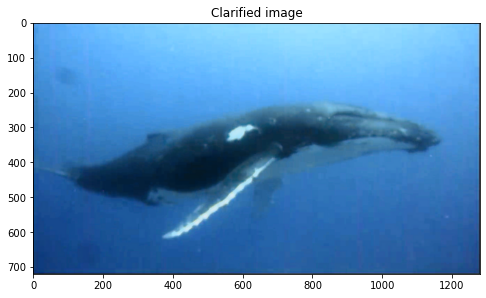

In [126]:
plt.figure(figsize=(8, 8))
plt.imshow(out_im)
plt.title("Clarified image")
plt.show()

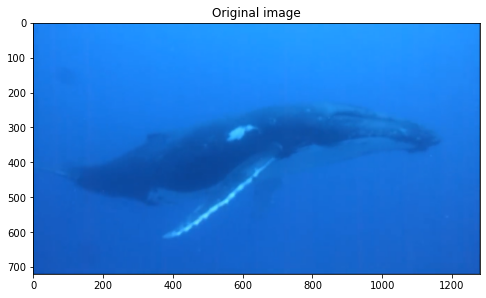

In [127]:
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Original image")
plt.show()

Original model seems to be kinda OK w/o further training.